In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', 99999)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


class Preprocessor:
    def __init__(self, target, train_df, test_df):
        self.target = target
        self.train_df = train_df
        self.test_df = test_df

        self.rare_categories_columns = ["MSSubClass", "MSZoning", "LotShape", "LotConfig", "LandSlope", 
                                            "ExterCond", "RoofStyle", "Foundation", "HeatingQC", "Electrical", 
                                            "BsmtFullBath", "BsmtHalfBath", "HalfBath", "KitchenAbvGr", "Fireplaces", 
                                            "GarageType", "GarageCars", "SaleType", "SaleCondition"]
        self.outliers_columns = ["LotFrontage", "LotArea", "MasVnrArea", "TotalBsmtSF", "1stFlrSF", 
                                                "GrLivArea", "SalePrice"]
        self.columns_to_drop = ["Id", "MiscVal", "Utilities", "Condition2", "YearRemodAdd", "RoofMatl", "Street", 
                              "BsmtFinSF2", "Heating", "Functional", "GarageQual", "GarageCond", "EnclosedPorch", 
                              "LowQualFinSF", "3SsnPorch", "ScreenPorch"]

        self.to_norm_columns = ["LotFrontage", "LotArea", "OverallQual", "OverallCond", "TotalBsmtSF", "1stFlrSF", 
                                 "GrLivArea", "BedroomAbvGr", "TotRmsAbvGrd", "YearBuilt", "GarageYrBlt", "MoSold", 
                                 "YrSold"]
        self.to_norm_non_zeros_column = ["GarageArea", "2ndFlrSF", "BsmtUnfSF", "BsmtFinSF1", "MasVnrArea", 
                                          "WoodDeckSF", "OpenPorchSF"]

        self.to_encode_columns = ["Fence", "HeatingQC", "BsmtFinType2", "BsmtFinType1", "BsmtQual", 
                                                    "MSSubClass", "MSZoning", "Alley", "LotShape", "LandContour", "LotConfig", 
                                                    "LandSlope", "Neighborhood", "Condition1", "BldgType", "HouseStyle", 
                                                    "RoofStyle", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", 
                                                    "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", 
                                                    "BsmtFinType1", "BsmtFinType2", "HeatingQC", "CentralAir", "Electrical", 
                                                    "BsmtFullBath", "FullBath", "HalfBath", "BsmtHalfBath", "KitchenQual", 
                                                    "Functional", "Fireplaces", "FireplaceQu", "GarageType", "GarageFinish", "PavedDrive", "SaleType", "SaleCondition", "Street"]

    def drop_columns_with_missing_values(self, df, alpha):
        threshold = alpha / 100 * len(df)
        columns_to_drop = df.columns[df.isnull().sum() > threshold]
        df.drop(columns=columns_to_drop, inplace=True)
        return df

    def one_hot_encode_columns(self, df, columns):
        onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
        columns_to_encode = df[self.inter(df.columns, columns)]
        encoded_data = onehot_encoder.fit_transform(columns_to_encode)
        encoded_columns = onehot_encoder.get_feature_names_out(columns_to_encode.columns)
        encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)
        df = df.drop(self.inter(df.columns, columns), axis=1)
        df = pd.concat([df, encoded_df], axis=1)
        return df

    def detect_and_drop_outliers(self, df, columns, iqr_multiplier=2):
        for col in self.inter(columns, df.columns):
            Q1 = df[col].quantile(0.075)
            Q3 = df[col].quantile(0.925)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        return df

    def drop_rare_categories(self, df, columns, max_drop_percentage=0.2):
        for col in columns:
            if col in df.columns:
                freq = df[col].value_counts(normalize=True)
                num_categories_to_examine = int(len(freq) * max_drop_percentage)
                categories_to_examine = freq.tail(num_categories_to_examine).index
                median_freq = freq[~freq.index.isin(categories_to_examine)].median()
                categories_to_drop = [cat for cat in categories_to_examine if freq[cat] < median_freq]
                df = df[~df[col].isin(categories_to_drop)]
        return df

    def normalize(self, df, columns, scaler=None):
        if scaler:
            df[columns] = scaler.transform(df[columns])
        else:
            scaler = StandardScaler()
            df[columns] = scaler.fit_transform(df[columns])
            
        return df, scaler

    def normalize_target(self, df):
        df[self.target] = StandardScaler().fit_transform(df[[self.target]])
        return df

    def normalize_non_zero(self, df, columns, scaler=None):
        combined_non_zero_mask = (df[columns] != 0).any(axis=1)
        if combined_non_zero_mask.any():
            non_zero_values = df.loc[combined_non_zero_mask, columns]
            if scaler:
                scaled_values = scaler.transform(non_zero_values)
            else:
                scaler = StandardScaler()
                scaled_values = scaler.fit_transform(non_zero_values)
                
            df.loc[combined_non_zero_mask, columns] = scaled_values
        return df, scaler

    def impute_missing_values(self, df, imputer=None):
        numeric_columns = df.select_dtypes(include=['number']).columns
        if imputer:
            imputed_data = imputer.fit_transform(df[numeric_columns])
        else:
            imputer = SimpleImputer(strategy='mean')
            imputed_data = imputer.fit_transform(df[numeric_columns])
            
        df[numeric_columns] = pd.DataFrame(imputed_data, columns=numeric_columns, index=df.index)
        return df, imputer

    def create_features(self, df):
        df["Pool"] = np.where(df["PoolArea"] > 0, 1, 0)
        return df

    def inter(self, cols1, cols2):
        return list(set(cols1).intersection(set(cols2)))

    def without(self, cols1, cols2):
        return list(set(cols1) - set(cols2))

    def drop_entire_columns(self, df):
        pass

    def set_numeric_to_float(self):
        def convert_column_type(column):
            if column.dtype.kind in 'iufc':  # includes int, uint, float, complex
                return column.astype('float64')
            return column
        
        self.train_df = self.train_df.apply(convert_column_type)
        self.test_df = self.test_df.apply(convert_column_type)
    
    def result(self):
        self.set_numeric_to_float()

        self.train_df = self.create_features(self.train_df)
        self.test_df = self.create_features(self.test_df)

        # Drop rows (only for train because we can't drop for test)
        self.train_df = self.detect_and_drop_outliers(self.train_df, self.outliers_columns)
        self.train_df = self.drop_rare_categories(self.train_df, self.rare_categories_columns)

        # Scale
        self.train_df, scaler = self.normalize(self.train_df, self.to_norm_columns)
        self.train_df, non_zeros_scaler = self.normalize_non_zero(self.train_df, self.to_norm_non_zeros_column)

        self.test_df, _ = self.normalize(self.test_df, self.to_norm_columns, scaler)
        self.test_df, _ = self.normalize_non_zero(self.test_df, self.to_norm_non_zeros_column, non_zeros_scaler)
        
        #self.train_df = self.normalize_target(self.train_df)

        # Impute
        self.train_df, imputer = self.impute_missing_values(self.train_df)
        self.test_df, _ = self.impute_missing_values(self.test_df, imputer)

        # Encode
        self.train_df = self.one_hot_encode_columns(self.train_df, self.to_encode_columns)
        self.test_df = self.one_hot_encode_columns(self.test_df, self.to_encode_columns)
        
        # Drop cols
        self.train_df = self.drop_columns_with_missing_values(self.train_df, 90)
        self.test_df = self.drop_columns_with_missing_values(self.test_df, 90)

        self.train_df = self.train_df.drop(columns=self.inter(self.train_df.columns, self.columns_to_drop))
        self.test_df = self.test_df.drop(columns=self.inter(self.test_df.columns, self.columns_to_drop))

        common_columns = self.inter(self.train_df.columns, self.test_df.columns)
        
        return self.train_df[common_columns + [self.target]], self.test_df[common_columns]

# Assuming train and test DataFrames are already defined
processor = Preprocessor("SalePrice", train, test)

train_processed, test_processed = processor.result()
print(processor.without(train_processed.columns, test_processed.columns))
print(processor.without(test_processed.columns, train_processed.columns))



['SalePrice']
[]


Grid Search Progress: 100%|█| 1728/1728 [08:30<00:00,  3.38it/s, Current score=809600206.5115, Best score=514755781.202


Meilleurs paramètres trouvés :  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7}
Meilleure MSE trouvée :  514755781.2022941
Mean Squared Error (MSE): 514755781.2023
Root Mean Squared Error (RMSE): 22688.2300
Mean Absolute Error (MAE): 15501.0889
R^2 Score: 0.9193


<Figure size 1000x800 with 0 Axes>

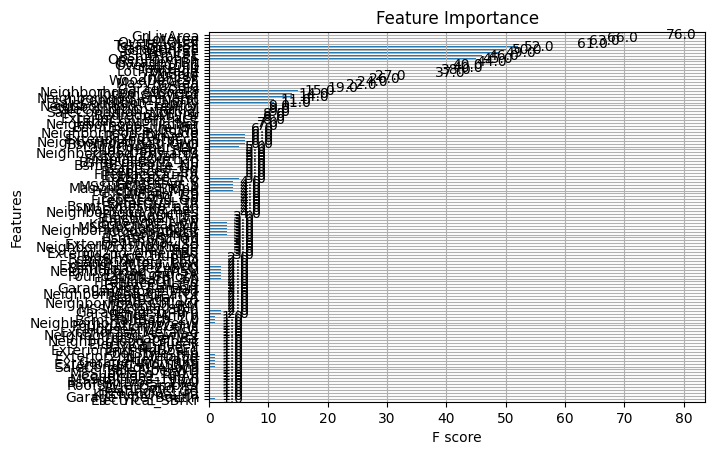

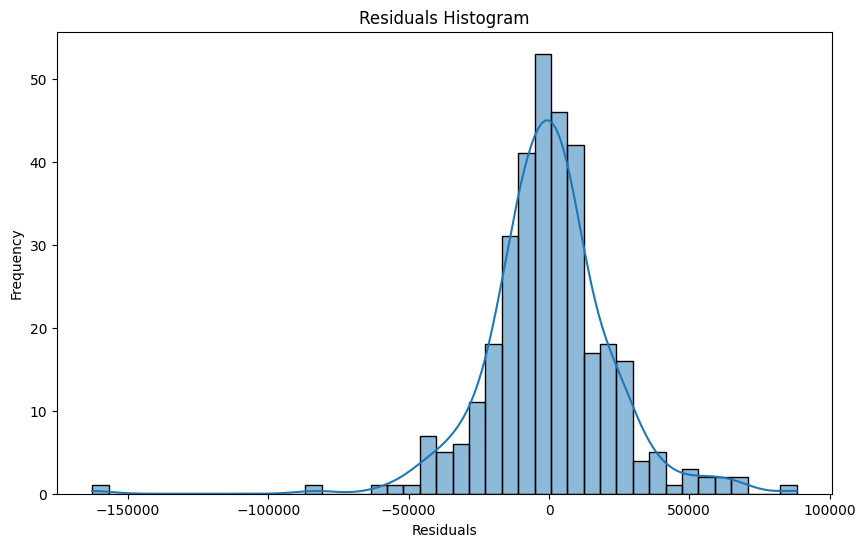

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

class XGBoostModelTuner:
    def __init__(self, train_df, test_df, target):
        """
        Initialise l'objet XGBoostModelTuner avec les DataFrames prétraités et le nom de la colonne cible.

        Paramètres:
        train_df (pd.DataFrame): Le DataFrame contenant les données d'entraînement.
        test_df (pd.DataFrame): Le DataFrame contenant les données de test.
        target (str): Le nom de la colonne cible.
        """
        self.train_df = train_df
        self.test_df = test_df
        self.target = target
        self.model = XGBRegressor()
        self.results = {}

    def prepare_data(self):
        """
        Prépare les données pour l'entraînement et le test.
        """
        X = self.train_df.drop(self.target, axis=1)
        y = self.train_df[self.target]
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    def tune_model(self):
        """
        Effectue la fine-tuning du modèle XGBoost en utilisant une recherche de grille personnalisée.
        """
        self.prepare_data()
        
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 9],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.7, 1],
            'colsample_bytree': [0.7, 1],
            'gamma': [0, 0.1],
            'min_child_weight': [1, 3],
            'reg_alpha': [0, 0.1],
            'reg_lambda': [0.5, 1]
        }
        
        param_list = list(ParameterGrid(param_grid))
        best_score = float('inf')
        best_params = None
        total_iterations = len(param_list)
        
        # Utiliser tqdm pour afficher la barre de progression
        pbar = tqdm(total=total_iterations, desc="Grid Search Progress")
    
        for i, params in enumerate(param_list):
            self.model.set_params(**params)
            self.model.fit(self.X_train, self.y_train)
            preds = self.model.predict(self.X_val)
            score = mean_squared_error(self.y_val, preds)
    
            if score < best_score:
                best_score = score
                best_params = params
            
            # Mettre à jour la barre de progression et afficher les scores en temps réel
            pbar.set_postfix({
                'Current score': f'{score:.4f}', 
                'Best score': f'{best_score:.4f}',
                'Iteration': f'{i+1}/{total_iterations}'
            })
            pbar.update(1)
        
        pbar.close()
    
        self.results['best_params'] = best_params

        # Calculer la meilleure MSE obtenue
        self.model = XGBRegressor(**best_params)
        self.model.fit(self.X_train, self.y_train)
        best_preds = self.model.predict(self.X_val)
        best_mse = mean_squared_error(self.y_val, best_preds)
        
        print("Meilleurs paramètres trouvés : ", best_params)
        print("Meilleure MSE trouvée : ", best_mse)

    def tune_model_grad(self, max_evals=1000):
        """
        Effectue la fine-tuning du modèle XGBoost en utilisant l'optimisation bayésienne avec hyperopt.
    
        Parameters:
        max_evals (int): Le nombre maximal d'évaluations à effectuer pour trouver les meilleurs hyperparamètres.
        """
        self.prepare_data()
        
        def objective(params):
            model = XGBRegressor(**params)
            model.fit(self.X_train, self.y_train)
            preds = model.predict(self.X_val)
            score = mean_squared_error(self.y_val, preds)
            return {'loss': score, 'status': STATUS_OK}
        
        param_space = {
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 50)),
            'max_depth': scope.int(hp.quniform('max_depth', 3, 9, 1)),
            'learning_rate': hp.loguniform('learning_rate', -5, -1),
            'subsample': hp.uniform('subsample', 0.6, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
            'gamma': hp.uniform('gamma', 0.0, 0.2),
            'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 5, 1)),
            'reg_alpha': hp.loguniform('reg_alpha', -3, 0),
            'reg_lambda': hp.uniform('reg_lambda', 1.0, 2.0)
        }
        
        trials = Trials()
        
        # Utiliser tqdm pour afficher la barre de progression
        with tqdm(total=max_evals, desc="Hyperopt Progress") as pbar:
            for i in range(max_evals):
                # Ajuster le learning rate après chaque itération
                if i > 0:
                    learning_rate_values = [trial['misc']['vals']['learning_rate'][0] for trial in trials.trials]
                    mean_learning_rate = sum(learning_rate_values) / len(learning_rate_values)
                    param_space['learning_rate'] = hp.loguniform('learning_rate', -5, -1) * mean_learning_rate
    
                fmin(fn=objective,
                     space=param_space,
                     algo=tpe.suggest,
                     max_evals=len(trials.trials) + 1,
                     trials=trials,
                     show_progressbar=False)  # Désactiver la barre de progression par défaut de fmin
                pbar.update(1)
        
        # Obtenir les meilleurs paramètres trouvés par hyperopt
        best = trials.best_trial['result']['loss']
        
        # Obtenir les paramètres associés au meilleur essai
        best_params = {key: int(trials.best_trial['misc']['vals'][key][0]) if key in ['n_estimators', 'max_depth', 'min_child_weight'] else trials.best_trial['misc']['vals'][key][0] for key in trials.best_trial['misc']['vals']}
        
        self.results['best_params'] = best_params
        
        # Calculer la meilleure MSE obtenue
        self.model = XGBRegressor(**best_params)
        self.model.fit(self.X_train, self.y_train)
        best_preds = self.model.predict(self.X_val)
        best_mse = mean_squared_error(self.y_val, best_preds)
        
        print("Meilleurs paramètres trouvés : ", best_params)
        print("Meilleure MSE trouvée : ", best_mse)
    
    def evaluate_model(self):
        """
        Évalue le modèle sur l'ensemble de validation et enregistre les statistiques.
        """
        y_pred = self.model.predict(self.X_val)
        mse = mean_squared_error(self.y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_val, y_pred)
        r2 = r2_score(self.y_val, y_pred)

        self.results['test_mse'] = mse
        self.results['test_rmse'] = rmse
        self.results['test_mae'] = mae
        self.results['r2_score'] = r2

        # Print statistics
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R^2 Score: {r2:.4f}")

    def plot_feature_importance(self):
        """
        Affiche les importances des caractéristiques du modèle XGBoost.
        """
        plt.figure(figsize=(10, 8))
        plot_importance(self.model, importance_type='weight')
        plt.title('Feature Importance')
        plt.show()

    def plot_residuals(self):
        """
        Affiche le graphique des résidus.
        """
        y_pred = self.model.predict(self.X_val)
        residuals = self.y_val - y_pred
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title('Residuals Histogram')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()
        self.residuals = residuals

    def run(self):
        """
        Exécute les étapes de fine-tuning, d'entraînement, d'évaluation et de génération des graphiques.
        """
        self.tune_model()
        self.evaluate_model()
        self.plot_feature_importance()
        self.plot_residuals()

    def predict(self):
        """
        Prédit les valeurs cibles pour les données de test en utilisant le modèle entraîné.
    
        Retourne:
        np.ndarray: Les prédictions du modèle.
        """
        predictions = self.model.predict(self.test_df)
        return predictions

def predict_save(tuner):
    predictions = tuner.predict()
    # Load the sample submission file
    submission = pd.read_csv("sample_submission.csv")
    #849764555
    #643001230
    # Update the "SalePrice" column with predictions
    submission["SalePrice"] = predictions
    
    # Drop the "Unnamed: 0" column if it exists
    if 'Unnamed: 0' in submission.columns:
        submission.drop(columns=['Unnamed: 0'], inplace=True)

    # Save the updated submission file without the index column
    submission.to_csv("sample_submission.csv", index=False)
    
tuner_XGB = XGBoostModelTuner(train_processed, test_processed, 'SalePrice')
tuner_XGB.run()
predict_save(tuner_XGB)

In [5]:
predict_save(tuner_XGB)

# LightGBM

Grid Search Progress: 100%|█| 2592/2592 [05:19<00:00,  8.11it/s, Current score=881107926.0330, Best score=660395699.259


Meilleurs paramètres trouvés :  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7}
Meilleure MSE trouvée :  660395699.2593486
Mean Squared Error (MSE): 660395699.2593
Root Mean Squared Error (RMSE): 25698.1653
Mean Absolute Error (MAE): 16785.7934
R^2 Score: 0.9035


<Figure size 1000x800 with 0 Axes>

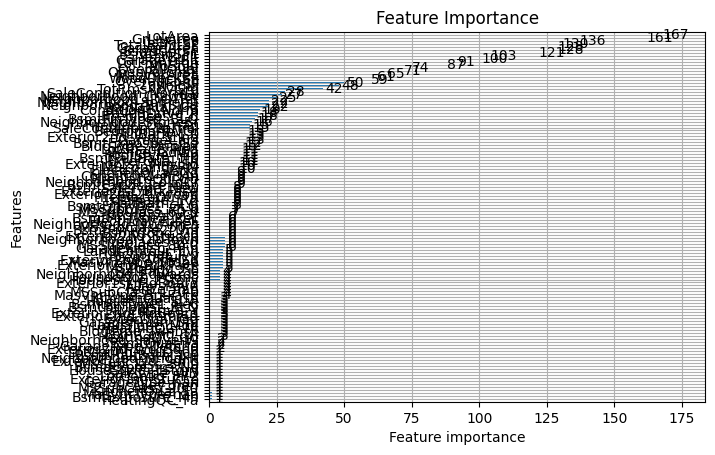

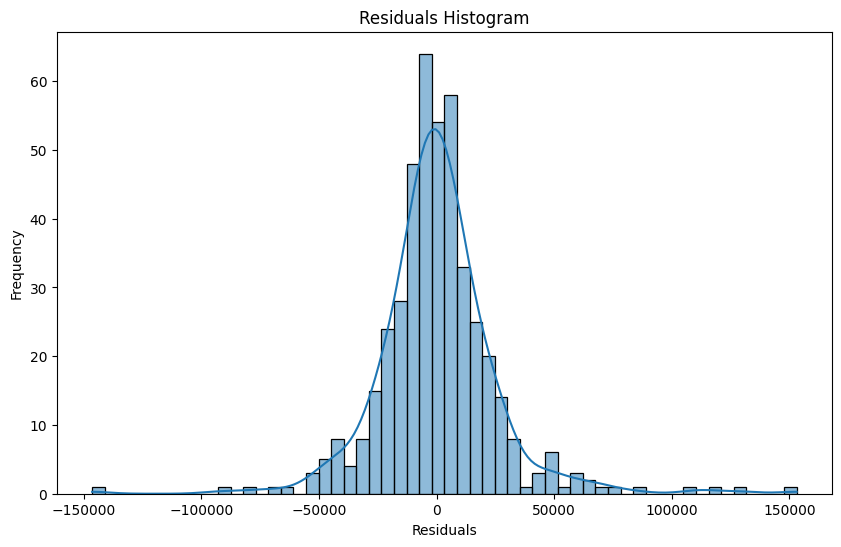

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import ParameterGrid
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from tqdm import tqdm

class LightGBMModelTuner:
    def __init__(self, train_df, test_df, target):
        """
        Initialise l'objet LightGBMModelTuner avec les DataFrames prétraités et le nom de la colonne cible.

        Paramètres:
        train_df (pd.DataFrame): Le DataFrame contenant les données d'entraînement.
        test_df (pd.DataFrame): Le DataFrame contenant les données de test.
        target (str): Le nom de la colonne cible.
        """
        self.train_df = train_df
        self.test_df = test_df
        self.target = target
        self.model = LGBMRegressor(verbose=-1)
        self.results = {}

    def prepare_data(self):
        """
        Prépare les données pour l'entraînement et le test.
        """
        X = self.train_df.drop(self.target, axis=1)
        y = self.train_df[self.target]
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.4, random_state=42)

    def tune_model(self):
        """
        Effectue la fine-tuning du modèle LightGBM en utilisant une recherche de grille personnalisée.
        """
        self.prepare_data()
        
        param_grid = {
            'n_estimators': [200, 500, 600],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.7, 1],
            'colsample_bytree': [0.7, 1],
            'min_child_samples': [10, 20, 30],
            'reg_alpha': [0, 0.1, 0.25],
            'reg_lambda': [0.5, 1]
        }
    
        param_list = list(ParameterGrid(param_grid))
        best_score = float('inf')
        best_params = None
        total_iterations = len(param_list)
        
        # Utiliser tqdm pour afficher la barre de progression
        pbar = tqdm(total=total_iterations, desc="Grid Search Progress")
    
        for i, params in enumerate(param_list):
            self.model.set_params(**params)
            self.model.fit(self.X_train, self.y_train)
            preds = self.model.predict(self.X_val)
            score = mean_squared_error(self.y_val, preds)
    
            if score < best_score:
                best_score = score
                best_params = params
            
            # Mettre à jour la barre de progression et afficher les scores en temps réel
            pbar.set_postfix({
                'Current score': f'{score:.4f}', 
                'Best score': f'{best_score:.4f}',
                'Iteration': f'{i+1}/{total_iterations}'
            })
            pbar.update(1)
        
        pbar.close()
    
        self.results['best_params'] = best_params
        
        # Calculer la meilleure MSE obtenue
        self.model = LGBMRegressor(**best_params, verbose=-1)
        self.model.fit(self.X_train, self.y_train)
        best_preds = self.model.predict(self.X_val)
        best_mse = mean_squared_error(self.y_val, best_preds)
        
        print("Meilleurs paramètres trouvés : ", best_params)
        print("Meilleure MSE trouvée : ", best_mse)

    def tune_model_grad(self, max_evals=1000):
        """
        Effectue la fine-tuning du modèle LightGBM en utilisant l'optimisation bayésienne avec hyperopt.
    
        Parameters:
        max_evals (int): Le nombre maximal d'évaluations à effectuer pour trouver les meilleurs hyperparamètres.
        """
        self.prepare_data()
        
        def objective(params):
            model = LGBMRegressor(**params, verbose=-1)
            model.fit(self.X_train, self.y_train)
            preds = model.predict(self.X_val)
            score = mean_squared_error(self.y_val, preds)
            return {'loss': score, 'status': STATUS_OK}
        
        param_space = {
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 50)),
            'max_depth': scope.int(hp.quniform('max_depth', 3, 9, 1)),
            'learning_rate': hp.loguniform('learning_rate', -5, -1),
            'subsample': hp.uniform('subsample', 0.6, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
            'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 50, 5)),
            'reg_alpha': hp.loguniform('reg_alpha', -3, 0),
            'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
            'num_leaves': scope.int(hp.quniform('num_leaves', 20, 150, 5)),
            'min_split_gain': hp.uniform('min_split_gain', 0.0, 1.0)
        }
                
        trials = Trials()
        
        # Utiliser tqdm pour afficher la barre de progression
        with tqdm(total=max_evals, desc="Hyperopt Progress") as pbar:
            for i in range(max_evals):
                # Ajuster le learning rate après chaque itération
                if i > 0:
                    learning_rate_values = [trial['misc']['vals']['learning_rate'][0] for trial in trials.trials]
                    mean_learning_rate = sum(learning_rate_values) / len(learning_rate_values)
                    param_space['learning_rate'] = hp.loguniform('learning_rate', -5, -1) * mean_learning_rate
    
                fmin(fn=objective,
                     space=param_space,
                     algo=tpe.suggest,
                     max_evals=len(trials.trials) + 1,
                     trials=trials,
                     show_progressbar=False)  # Désactiver la barre de progression par défaut de fmin
                pbar.update(1)
        
        # Obtenir les meilleurs paramètres trouvés par hyperopt
        best = trials.best_trial['result']['loss']
        
        # Obtenir les paramètres associés au meilleur essai
        best_params = {key: int(trials.best_trial['misc']['vals'][key][0]) if key in ['n_estimators', 'max_depth', 'min_child_samples', 'num_leaves'] else trials.best_trial['misc']['vals'][key][0] for key in trials.best_trial['misc']['vals']}
        
        self.results['best_params'] = best_params
        
        # Calculer la meilleure MSE obtenue
        self.model = LGBMRegressor(**best_params, verbose=-1)
        self.model.fit(self.X_train, self.y_train)
        best_preds = self.model.predict(self.X_val)
        best_mse = mean_squared_error(self.y_val, best_preds)
        
        print("Meilleurs paramètres trouvés : ", best_params)
        print("Meilleure MSE trouvée : ", best_mse)
    
    def evaluate_model(self):
        """
        Évalue le modèle sur l'ensemble de validation et enregistre les statistiques.
        """
        y_pred = self.model.predict(self.X_val)
        mse = mean_squared_error(self.y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_val, y_pred)
        r2 = r2_score(self.y_val, y_pred)

        self.results['test_mse'] = mse
        self.results['test_rmse'] = rmse
        self.results['test_mae'] = mae
        self.results['r2_score'] = r2

        # Print statistics
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R^2 Score: {r2:.4f}")

    def plot_feature_importance(self):
        """
        Affiche les importances des caractéristiques du modèle LightGBM.
        """
        plt.figure(figsize=(10, 8))
        plot_importance(self.model, importance_type='split')
        plt.title('Feature Importance')
        plt.show()

    def plot_residuals(self):
        """
        Affiche le graphique des résidus.
        """
        y_pred = self.model.predict(self.X_val)
        residuals = self.y_val - y_pred
        self.residuals = residuals
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title('Residuals Histogram')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()

    def run(self):
        """
        Exécute les étapes de fine-tuning, d'entraînement, d'évaluation et de génération des graphiques.
        """
        self.tune_model()
        self.evaluate_model()
        self.plot_feature_importance()
        self.plot_residuals()

    def predict(self):
        """
        Prédit les valeurs cibles pour les données de test en utilisant le modèle entraîné.
    
        Retourne:
        np.ndarray: Les prédictions du modèle.
        """
        predictions = self.model.predict(self.test_df)
        return predictions

tuner_LGBM = LightGBMModelTuner(train_processed, test_processed, 'SalePrice')
tuner_LGBM.run()
predict_save(tuner_LGBM)

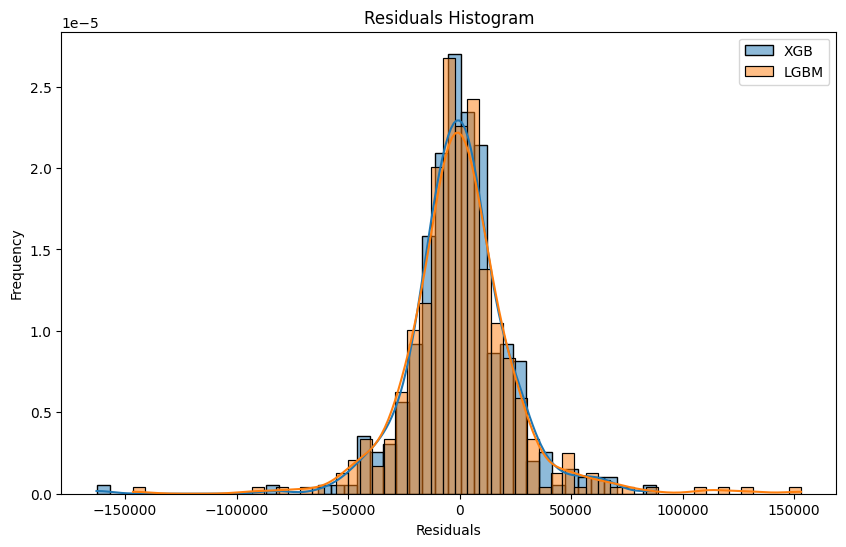

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(tuner_XGB.residuals, kde=True, alpha=0.5, label="XGB", stat='density')
sns.histplot(tuner_LGBM.residuals, kde=True, alpha=0.5, label="LGBM", stat='density')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [234]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ModelEvaluator:
    def __init__(self, df, target):
        """
        Initialise l'objet ModelEvaluator avec un DataFrame et le nom de la colonne cible.

        Paramètres:
        df (pd.DataFrame): Le DataFrame contenant les données.
        target (str): Le nom de la colonne cible.
        """
        self.df = df
        self.target = target
        self.models = {
            "Linear Regression": LinearRegression(),
            "Ridge Regression": Ridge(),
            "Lasso Regression": Lasso(),
            "ElasticNet": ElasticNet(),
            "Bayesian Ridge": BayesianRidge(),
            "Random Forest": RandomForestRegressor(),
            "Gradient Boosting": GradientBoostingRegressor(),
            "AdaBoost": AdaBoostRegressor(),
            "Support Vector Regression": SVR(),
            "K-Neighbors Regressor": KNeighborsRegressor(),
            "Decision Tree": DecisionTreeRegressor(),
            "MLP Regressor": MLPRegressor(),
            "XGBoost": XGBRegressor(),
            "LightGBM": LGBMRegressor()
        }
        self.results = {}

    def prepare_data(self):
        """
        Prépare les données pour l'entraînement et le test.
        """
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def evaluate_models(self):
        """
        Entraîne et évalue les modèles en utilisant la validation croisée et l'ensemble de test.
        """
        self.prepare_data()
        for name, model in self.models.items():
            print(f'Testing model {name}...')
            # Validation croisée
            scores = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring='neg_mean_squared_error')
            mean_cv_score = -scores.mean()

            # Entraînement sur l'ensemble d'entraînement complet et évaluation sur l'ensemble de test
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            test_mse = mean_squared_error(self.y_test, y_pred)
            test_rmse = np.sqrt(test_mse)
            test_mae = mean_absolute_error(self.y_test, y_pred)
            test_r2 = r2_score(self.y_test, y_pred)

            # Stockage des résultats
            self.results[name] = {
                "Cross-Validation MSE": mean_cv_score,
                "Test MSE": test_mse,
                "Test RMSE": test_rmse,
                "Test MAE": test_mae,
                "Test R^2": test_r2
            }

    def print_results(self):
        """
        Affiche les résultats des modèles.
        """
        for name, metrics in self.results.items():
            print(f"{name}:")
            print(f"  Cross-Validation Mean Squared Error: {metrics['Cross-Validation MSE']:.4f}")
            print(f"  Test Mean Squared Error: {metrics['Test MSE']:.4f}")
            print(f"  Test Root Mean Squared Error: {metrics['Test RMSE']:.4f}")
            print(f"  Test Mean Absolute Error: {metrics['Test MAE']:.4f}")
            print(f"  Test R^2 Score: {metrics['Test R^2']:.4f}\n")

# Example usage
m = ModelEvaluator(train_processed, "SalePrice")
m.evaluate_models()
m.print_results()


Testing model Linear Regression...
Testing model Ridge Regression...
Testing model Lasso Regression...


C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.486e+10, tolerance: 4.353e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+11, tolerance: 4.450e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

Testing model ElasticNet...
Testing model Bayesian Ridge...
Testing model Random Forest...
Testing model Gradient Boosting...
Testing model AdaBoost...
Testing model Support Vector Regression...
Testing model K-Neighbors Regressor...
Testing model Decision Tree...
Testing model MLP Regressor...


C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dimma\anaconda3

Testing model XGBoost...
Testing model LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 716, number of used features: 136
[LightGBM] [Info] Start training from score 181154.203911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [2]:
import pandas as pd
from ydata_profiling import ProfileReport

# Load your DataFrame (replace with your data loading method)
df = pd.read_csv('train.csv')

# Generate a profiling report
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

# Save the report as an HTML file
profile.to_file("data_profile_report.html")


C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Summarize dataset:  94%|█████████████████████████████████  | 83/88 [00:01<00:00, 76.83it/s, Calculate auto correlation]C:\Users\dimma\anaconda3\envs\kaggle\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Grvl'')
  warnings.warn(
Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:0

In [69]:
def convert_str_to_number(s):
    try:
        # Essayer de convertir en int
        return int(s)
    except ValueError:
        try:
            # Essayer de convertir en float
            return float(s)
        except ValueError:
            # Lever une exception si la conversion échoue
            raise ValueError(f"La valeur '{s}' ne peut être convertie ni en int ni en float.")


def check(s):
    s1 = s[1:-1].split(",")
    a = convert_str_to_number(s1[0])
    b = convert_str_to_number(s1[1])
    print(str(a) + ", " + str(b), s)

    return len(s) - 2 == len(str(a) + ", " + str(b))

check("(1.0, 3.00)")

1.0, 3.0 (1.0, 3.00)


False